# Titanic - Machine Learning from Disasters
## Kaggle Competition

#### RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early hours of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. RMS Titanic was the largest ship afloat at the time she entered service and was the second of three Olympic-class ocean liners operated by the White Star Line.

### In this exercise, we will try to predict whether a passenger on the Titanic would have survived or not.

### Import the necessary libraries

In [1]:
# Import our libraries
import pandas as pd
import numpy as np

# Import sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc, make_scorer, confusion_matrix, f1_score, fbeta_score

# Import the Naive Bayes, logistic regression, Bagging, RandomForest, AdaBoost, GradientBoost, Decision Trees and SVM Classifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import style
#plt.style.use('bmh')
#plt.style.use('ggplot')
plt.style.use('seaborn-notebook')

from matplotlib.ticker import StrMethodFormatter

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer


### Read the training and testing data

In [2]:
#titanic_features = pd.read_csv('train.csv')
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

### Exploratory Analysis

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train_df.shape

(891, 12)

In [5]:
test_df.shape

(418, 11)

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Features:
* `survival`: Survival 
* `PassengerId`: Unique Id of a passenger
* `pclass`: Ticket class     
* `sex`: Sex     
* `Age`: Age in years     
* `sibsp`: # of siblings / spouses aboard the Titanic     
* `parch`: # of parents / children aboard the Titanic     
* `ticket`: Ticket number     
* `fare`: Passenger fare     
* `cabin`: Cabin number     
* `embarked`: Port of Embarkation

In [8]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### From the table above, we can note a few things:
* ##### We have a few categorical variabes that need to be either converted to numerical or one-hot encoded, so that the machine learning algorithms can process them. 
* ##### The features have widely different ranges, and we will need to convert into roughly the same scale. 
* ##### Some features contain missing values (NaN = not a number), that we need to deal with.

### Missing data 

`Age` and `Embarked`

In [9]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


##### The `Embarked` feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the `Age` feature, which has 177 missing values. The `Cabin` feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [10]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

#### Suppress warnings from output

In [11]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Q1: How many people Embarked from different ports? Is there a correlation between port of embarkment and survival? 

In [12]:
train_df['Embarked'].value_counts()/len(train_df)

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

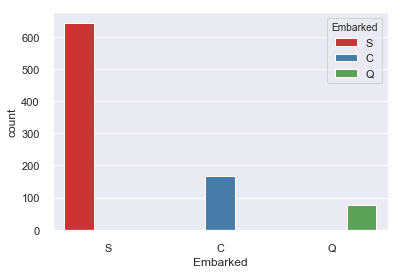

In [13]:
sns.set(style="darkgrid")
sns.countplot( x='Embarked', data=train_df, hue="Embarked", palette="Set1");

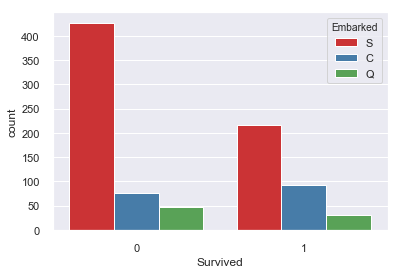

In [14]:
sns.set(style="darkgrid")
sns.countplot( x='Survived', data=train_df, hue="Embarked", palette="Set1");

In [15]:
train_df.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


### Q2: Does survival depend upon gender?

In [16]:
train_df.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893


/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


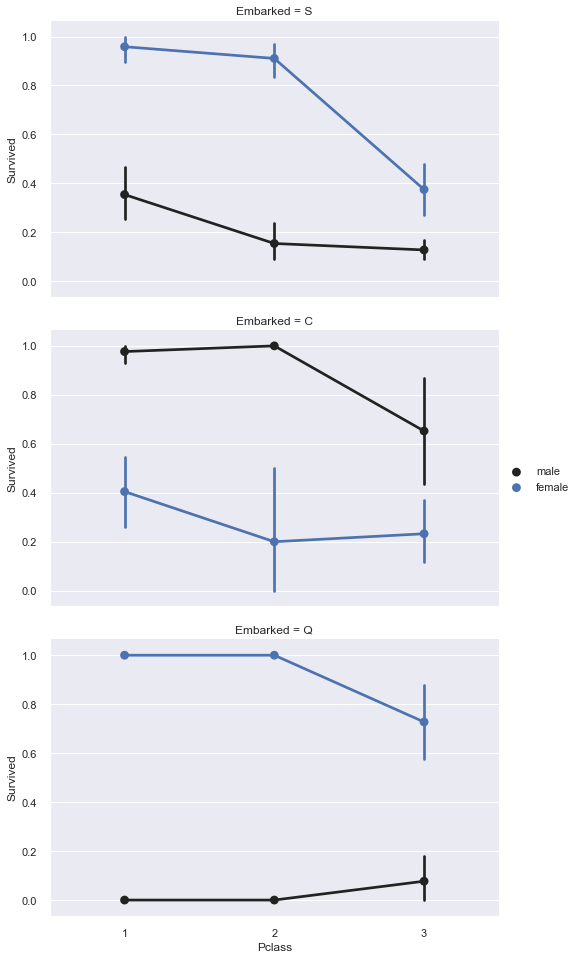

In [17]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

* ##### Embarked seems to be correlated with survival, depending on the gender.

* ##### Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

* ##### Pclass also seems to be correlated with survival. We will generate another plot of it below.

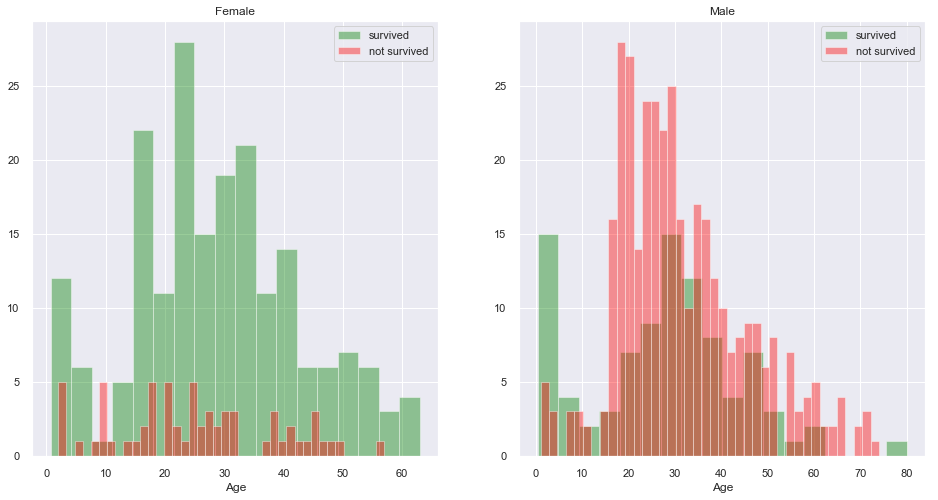

In [18]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16, 8))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False, color="green")
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False, color="red")
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False, color="green")
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False, color="red")
ax.legend()
_ = ax.set_title('Male');

* ##### You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

* ##### For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

* ##### Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.

#### Pclass

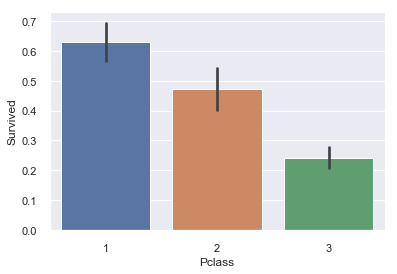

In [19]:
sns.barplot(x='Pclass', y='Survived', data=train_df);

##### Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


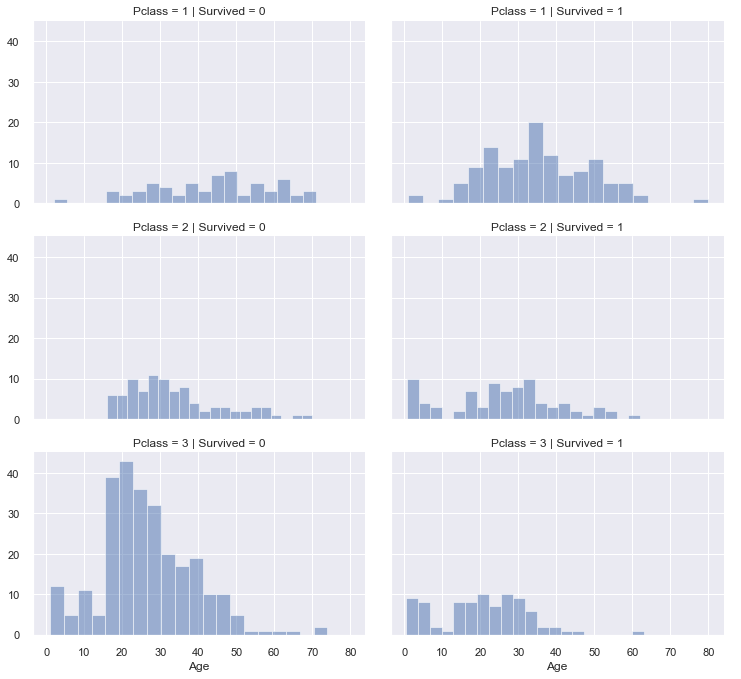

In [20]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=3.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

##### The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

#### `SibSp` and `Parch`

##### SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [21]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'travelled_alone'] = 'No'
    dataset.loc[dataset['relatives'] == 0, 'travelled_alone'] = 'Yes'
    #dataset['travelled_alone'] = dataset['travelled_alone'].astype(int)
train_df['travelled_alone'].value_counts()

Yes    537
No     354
Name: travelled_alone, dtype: int64

In [22]:
test_df['travelled_alone'].value_counts()

Yes    253
No     165
Name: travelled_alone, dtype: int64

In [23]:
train_df['relatives'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: relatives, dtype: int64

### Q3: Do the passengers have better chance at survival while travelling alone?

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


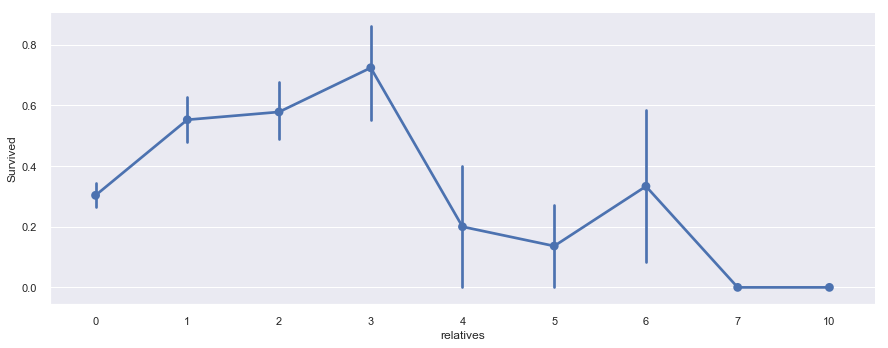

In [24]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, );

##### Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

### Data Preprocessing

In [25]:
# Drop 'PassengerId' from the train set, because it does not contribute to a persons survival probability.
train_df = train_df.drop(['PassengerId'], axis=1)

#### Missing Data

#### Cabin:
##### Cabin number looks like ‘C23’ and the letter refers to the deck. We will extract these and create a new feature, to represent a persons deck. 

In [26]:
train_df['Cabin'].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [27]:
import re
deck = {"A": "A", "B": "B", "C": "C", "D": "D", "E": "E", "F": "F", "G": "G", "U": "U"}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna("U")
    #dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [28]:
train_df['Deck'].value_counts()

U    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Deck, dtype: int64

In [29]:
train_df.groupby('Deck').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,relatives
Deck,,,,,,,
A,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887,0.266667
B,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764,0.936170
C,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341,1.118644
D,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576,0.727273
E,0.750000,1.312500,38.116667,0.312500,0.312500,46.026694,0.625000
F,0.615385,2.384615,19.954545,0.538462,0.538462,18.696792,1.076923
G,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250,1.750000
U,0.299419,2.636628,27.588208,0.546512,0.364826,19.181079,0.911337


In [30]:
test_df['Deck'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

#### Age:
##### Fill null values with random numbers, which are computed based on the mean age value in regards to the standard deviation.

In [31]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [32]:
train_df["Age"].isnull().sum()

0

In [33]:
test_df["Age"].isnull().sum()

0

In [34]:
train_df["Age"].describe()

count    891.000000
mean      29.355780
std       13.536809
min        0.000000
25%       20.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [ ]:
#train_df.groupby('Age').mean()

#### Embarked:

In [35]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [36]:
train_df['Embarked'].mode()

0    S
dtype: object

In [37]:
#common_value = train_df['Embarked'].mode()
#common_value

In [38]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [39]:
test_df['Embarked'].describe()

count     418
unique      3
top         S
freq      270
Name: Embarked, dtype: object

### Converting Features

#### Fare: Convert from float to int

In [40]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [41]:
train_df['Fare'].describe()

count    891.000000
mean      31.785634
std       49.703730
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

In [42]:
train_df['Fare'].isnull().sum()

0

In [43]:
test_df['Fare'].describe()

count    418.000000
mean      35.100478
std       55.872752
min        0.000000
25%        7.000000
50%       14.000000
75%       31.000000
max      512.000000
Name: Fare, dtype: float64

In [44]:
test_df['Fare'].isnull().sum()

0

In [45]:
train_df['Fare'] = train_df['Fare'].astype(int)

In [46]:
test_df['Fare'] = test_df['Fare'].astype(int)

#### Name: Extract titles from name and build a new feature from that

In [47]:
train_titles = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
type(train_titles)

pandas.core.series.Series

In [48]:
train_titles.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Jonkheer      1
Sir           1
Countess      1
Capt          1
Ms            1
Mme           1
Don           1
Lady          1
Name: Name, dtype: int64

In [49]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    #dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna("NA")
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [50]:
train_df.groupby(['Title']).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare,relatives
Title,,,,,,,
Master,0.575000,2.625000,7.400000,2.300000,1.375000,34.250000,3.675000
Miss,0.702703,2.291892,23.070270,0.702703,0.540541,43.340541,1.243243
Mr,0.156673,2.410058,31.251451,0.288201,0.152805,24.021277,0.441006
Mrs,0.793651,1.992063,34.865079,0.690476,0.825397,44.984127,1.515873
Rare,0.347826,1.347826,45.304348,0.347826,0.086957,36.782609,0.434783


In [51]:
test_df.groupby(['Title']).mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,relatives
Title,,,,,,,
Master,1123.380952,2.714286,28.238095,1.571429,1.380952,38.142857,2.952381
Miss,1100.240506,2.443038,28.607595,0.544304,0.392405,39.139241,0.936709
Mr,1101.279167,2.320833,28.433333,0.270833,0.175000,25.016667,0.445833
Mrs,1090.097222,1.833333,29.277778,0.597222,0.833333,59.611111,1.430556
Rare,1117.500000,1.333333,27.500000,0.500000,0.333333,80.500000,0.833333


#### Sex: Convert to numeric

In [52]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [53]:

genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)



#### Ticket:

In [55]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [56]:
test_df['Ticket'].describe()

count          418
unique         363
top       PC 17608
freq             5
Name: Ticket, dtype: object

##### Since the Ticket attribute has too many unique values, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [57]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

#### Embarked: Convert to Numeric

In [59]:

ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)
    
    

### Create new features

#### Age times class

In [62]:

data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']
    
    

#### Fare per Person:

In [63]:

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
    

### Creating categories:

#### Age: Convert from float to int and create a new feature "AgeGroup" using bins 

In [64]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7
    
    dataset['Age'] = dataset['Age'].astype(str)
    dataset.loc[ dataset['Age'] == '0', 'Age'] = "Children"
    dataset.loc[ dataset['Age'] == '1', 'Age'] = "Teens"
    dataset.loc[ dataset['Age'] == '2', 'Age'] = "Youngsters"
    dataset.loc[ dataset['Age'] == '3', 'Age'] = "Young Adults"
    dataset.loc[ dataset['Age'] == '4', 'Age'] = "Adults"
    dataset.loc[ dataset['Age'] == '5', 'Age'] = "Middle Age"
    dataset.loc[ dataset['Age'] == '6', 'Age'] = "Senior"
    dataset.loc[ dataset['Age'] == '7', 'Age'] = "Retired"

# let's see how it's distributed 
train_df['Age'].value_counts()

Adults          160
Middle Age      153
Senior          148
Young Adults    137
Youngsters      115
Teens           103
Children         68
Retired           7
Name: Age, dtype: int64

In [65]:
test_df['Age'].value_counts()

Adults          79
Middle Age      71
Young Adults    65
Youngsters      61
Senior          61
Teens           46
Children        33
Retired          2
Name: Age, dtype: int64

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null int64
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null int64
Embarked           891 non-null int64
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(10), object(4)
memory usage: 97.5+ KB


#### Fare:

In [67]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset['Fare'] = dataset['Fare'].astype(str)
    dataset.loc[ dataset['Fare'] == '0', 'Fare'] = "Extremely Low"
    dataset.loc[ dataset['Fare'] == '1', 'Fare'] = "Very Low"
    dataset.loc[ dataset['Fare'] == '2', 'Fare'] = "Low"
    dataset.loc[ dataset['Fare'] == '3', 'Fare'] = "High"
    dataset.loc[ dataset['Fare'] == '4', 'Fare'] = "Very High"
    dataset.loc[ dataset['Fare'] == '5', 'Fare'] = "Extremely High"
    

In [68]:
train_df['Fare'].value_counts()

Extremely Low     241
Low               223
Very Low          216
High              158
Very High          44
Extremely High      9
Name: Fare, dtype: int64

In [69]:
test_df['Fare'].value_counts()

Extremely Low     120
Low               102
Very Low           96
High               69
Very High          23
Extremely High      8
Name: Fare, dtype: int64

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null int64
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null int64
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(9), object(5)
memory usage: 97.5+ KB


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Sex                418 non-null int64
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null int64
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(9), object(5)
memory usage: 45.8+ KB


In [72]:
# Let's take a last look at the training set
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,3,0,Youngsters,1,0,Extremely Low,0,1,No,U,Mr,66,3
1,1,1,1,Middle Age,1,0,High,1,1,No,C,Mrs,38,35
2,1,3,1,Young Adults,0,0,Extremely Low,0,0,Yes,U,Miss,78,7
3,1,1,1,Middle Age,1,0,High,0,1,No,C,Mrs,35,26
4,0,3,0,Middle Age,0,0,Very Low,0,0,Yes,U,Mr,105,8
5,0,3,0,Middle Age,0,0,Very Low,2,0,Yes,U,Mr,105,8
6,0,1,0,Senior,0,0,High,0,0,Yes,E,Mr,54,51
7,0,3,0,Children,3,1,Low,0,4,No,U,Master,6,4
8,1,3,1,Young Adults,0,2,Very Low,0,2,No,U,Mrs,81,3
9,1,2,1,Teens,1,0,Low,1,1,No,U,Mrs,28,15


In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Sex                891 non-null int64
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null int64
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(9), object(5)
memory usage: 97.5+ KB


In [74]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null int64
Sex                418 non-null int64
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null int64
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(9), object(5)
memory usage: 45.8+ KB


In [75]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [76]:
data = [train_df, test_df]

for dataset in data:
    dataset['Pclass'] = dataset['Pclass'].astype(str)
    dataset.loc[ dataset['Pclass'] == '1', 'Pclass'] = "Class1"
    dataset.loc[ dataset['Pclass'] == '2', 'Pclass'] = "Class2"
    dataset.loc[ dataset['Pclass'] == '3', 'Pclass'] = "Class3"
    

In [77]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived           891 non-null int64
Pclass             891 non-null object
Sex                891 non-null int64
Age                891 non-null object
SibSp              891 non-null int64
Parch              891 non-null int64
Fare               891 non-null object
Embarked           891 non-null int64
relatives          891 non-null int64
travelled_alone    891 non-null object
Deck               891 non-null object
Title              891 non-null object
Age_Class          891 non-null int64
Fare_Per_Person    891 non-null int64
dtypes: int64(8), object(6)
memory usage: 97.5+ KB


In [78]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId        418 non-null int64
Pclass             418 non-null object
Sex                418 non-null int64
Age                418 non-null object
SibSp              418 non-null int64
Parch              418 non-null int64
Fare               418 non-null object
Embarked           418 non-null int64
relatives          418 non-null int64
travelled_alone    418 non-null object
Deck               418 non-null object
Title              418 non-null object
Age_Class          418 non-null int64
Fare_Per_Person    418 non-null int64
dtypes: int64(8), object(6)
memory usage: 45.8+ KB


In [79]:
train_df['Pclass'].value_counts()

Class3    491
Class1    216
Class2    184
Name: Pclass, dtype: int64

## Scaling the numerical data

In [80]:
# Capture all the numerical features so that we can scale them later
#data = [train_df, test_df]
train_numerical_features = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_numerical_features

['Survived',
 'Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'relatives',
 'Age_Class',
 'Fare_Per_Person']

In [81]:
type(train_numerical_features)

list

In [82]:
del train_numerical_features[0]
train_numerical_features

['Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'relatives',
 'Age_Class',
 'Fare_Per_Person']

In [83]:
# Feature scaling - Standard scaler
ss_scaler = StandardScaler()
train_df_ss = pd.DataFrame(data = train_df)
train_df_ss[train_numerical_features] = ss_scaler.fit_transform(train_df_ss[train_numerical_features])

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [84]:
train_df_ss.shape

(891, 14)

In [85]:
train_df_ss.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,0,Class3,-0.737695,Youngsters,0.432793,-0.473674,Extremely Low,-0.568837,0.059160,No,U,Mr,0.056828,-0.459218
1,1,Class1,1.355574,Middle Age,0.432793,-0.473674,High,1.005181,0.059160,No,C,Mrs,-0.768395,0.434090
2,1,Class3,1.355574,Young Adults,-0.474545,-0.473674,Extremely Low,-0.568837,-0.560975,Yes,U,Miss,0.410494,-0.347554
3,1,Class1,1.355574,Middle Age,0.432793,-0.473674,High,-0.568837,0.059160,No,C,Mrs,-0.856812,0.182847
4,0,Class3,-0.737695,Middle Age,-0.474545,-0.473674,Very Low,-0.568837,-0.560975,Yes,U,Mr,1.206245,-0.319638


In [86]:
test_numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_numerical_features

['PassengerId',
 'Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'relatives',
 'Age_Class',
 'Fare_Per_Person']

In [87]:
del test_numerical_features[0]
test_numerical_features

['Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'relatives',
 'Age_Class',
 'Fare_Per_Person']

In [88]:
# Feature scaling - Standard scaler
test_ss_scaler = StandardScaler()
test_df_ss = pd.DataFrame(data = test_df)
test_df_ss[test_numerical_features] = test_ss_scaler.fit_transform(test_df_ss[test_numerical_features])

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [89]:
test_df.shape

(418, 14)

In [90]:
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,travelled_alone,Deck,Title,Age_Class,Fare_Per_Person
0,892,Class3,-0.755929,Youngsters,-0.499470,-0.400248,Extremely Low,2.243165,-0.553443,Yes,U,Mr,0.017736,-0.401204
1,893,Class3,1.322876,Middle Age,0.616992,-0.400248,Extremely Low,-0.677841,0.105643,No,U,Mrs,1.211875,-0.513662
2,894,Class2,-0.755929,Young Adults,-0.499470,-0.400248,Very Low,2.243165,-0.553443,Yes,U,Mr,-0.330555,-0.344975
3,895,Class3,-0.755929,Middle Age,-0.499470,-0.400248,Very Low,-0.677841,-0.553443,Yes,U,Mr,0.987974,-0.373089
4,896,Class3,1.322876,Middle Age,0.616992,0.619896,Very Low,-0.677841,0.764728,No,U,Mrs,0.987974,-0.485547


## One-hot encoding

In [91]:
# One-Hot encoding / Dummy variables
encode_col_list = list(train_df.select_dtypes(include=['object']).columns)
for i in encode_col_list:
    train_df_ss = pd.concat([train_df_ss,pd.get_dummies(train_df_ss[i], prefix=i)],axis=1)
    train_df_ss.drop(i, axis = 1, inplace=True)

In [92]:
train_df_ss.shape

(891, 40)

In [93]:
train_df_ss.head()

,Survived,Sex,SibSp,Parch,Embarked,relatives,Age_Class,Fare_Per_Person,Pclass_Class1,Pclass_Class2,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,-0.737695,0.432793,-0.473674,-0.568837,0.059160,0.056828,-0.459218,0,0,...,0,0,0,0,1,0,0,1,0,0
1,1,1.355574,0.432793,-0.473674,1.005181,0.059160,-0.768395,0.434090,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,1.355574,-0.474545,-0.473674,-0.568837,-0.560975,0.410494,-0.347554,0,0,...,0,0,0,0,1,0,1,0,0,0
3,1,1.355574,0.432793,-0.473674,-0.568837,0.059160,-0.856812,0.182847,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,-0.737695,-0.474545,-0.473674,-0.568837,-0.560975,1.206245,-0.319638,0,0,...,0,0,0,0,1,0,0,1,0,0


In [94]:
# One-Hot encoding / Dummy variables
test_encode_col_list = list(test_df.select_dtypes(include=['object']).columns)
for i in test_encode_col_list:
    test_df_ss = pd.concat([test_df_ss,pd.get_dummies(test_df_ss[i], prefix=i)],axis=1)
    test_df_ss.drop(i, axis = 1, inplace=True)

In [95]:
test_df_ss.shape

(418, 40)

In [96]:
test_df_ss.head()

,PassengerId,Sex,SibSp,Parch,Embarked,relatives,Age_Class,Fare_Per_Person,Pclass_Class1,Pclass_Class2,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,892,-0.755929,-0.499470,-0.400248,2.243165,-0.553443,0.017736,-0.401204,0,0,...,0,0,0,0,1,0,0,1,0,0
1,893,1.322876,0.616992,-0.400248,-0.677841,0.105643,1.211875,-0.513662,0,0,...,0,0,0,0,1,0,0,0,1,0
2,894,-0.755929,-0.499470,-0.400248,2.243165,-0.553443,-0.330555,-0.344975,0,1,...,0,0,0,0,1,0,0,1,0,0
3,895,-0.755929,-0.499470,-0.400248,-0.677841,-0.553443,0.987974,-0.373089,0,0,...,0,0,0,0,1,0,0,1,0,0
4,896,1.322876,0.616992,0.619896,-0.677841,0.764728,0.987974,-0.485547,0,0,...,0,0,0,0,1,0,0,0,1,0


## ML Modelling

In [97]:
X_train = train_df_ss.drop("Survived", axis=1)
Y_train = train_df_ss["Survived"]
X_test  = test_df_ss.drop("PassengerId", axis=1).copy()

In [98]:
X_train.shape

(891, 39)

In [99]:
Y_train.shape

(891,)

In [100]:
X_test.shape

(418, 39)

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
Sex                    891 non-null float64
SibSp                  891 non-null float64
Parch                  891 non-null float64
Embarked               891 non-null float64
relatives              891 non-null float64
Age_Class              891 non-null float64
Fare_Per_Person        891 non-null float64
Pclass_Class1          891 non-null uint8
Pclass_Class2          891 non-null uint8
Pclass_Class3          891 non-null uint8
Age_Adults             891 non-null uint8
Age_Children           891 non-null uint8
Age_Middle Age         891 non-null uint8
Age_Retired            891 non-null uint8
Age_Senior             891 non-null uint8
Age_Teens              891 non-null uint8
Age_Young Adults       891 non-null uint8
Age_Youngsters         891 non-null uint8
Fare_Extremely High    891 non-null uint8
Fare_Extremely Low     891 non-null uint8
Fare_High              891 non-null uint8

## Logistic Regression

In [ ]:
# Instantiate our model
logreg = LogisticRegression()

# Fit our model to the training data
logreg.fit(X_train, Y_train)

# Predict on the test data
logreg_predictions = logreg.predict(X_test)

logreg_data = pd.read_csv('data/test.csv')
logreg_data.insert((logreg_data.shape[1]),'Survived',logreg_predictions)

logreg_data.to_csv('LogisticRegression_SS_OH_FE2.csv')

## Adaptive Boosting

In [ ]:
# Instantiate our model
adaboost = AdaBoostClassifier()

# Fit our model to the training data
adaboost.fit(X_train, Y_train)

# Predict on the test data
adaboost_predictions = adaboost.predict(X_test)

adaboost_data = pd.read_csv('data/test.csv')
adaboost_data.insert((adaboost_data.shape[1]),'Survived',adaboost_predictions)

adaboost_data.to_csv('AdaptiveBoosting_SS_OH_FE.csv')

## Bagging Classifier

In [ ]:
# Instantiate our model
bag = BaggingClassifier()

# Fit our model to the training data
bag.fit(X_train, Y_train)

# Predict on the test data
bag_predictions = bag.predict(X_test)

bag_data = pd.read_csv('data/test.csv')
bag_data.insert((bag_data.shape[1]),'Survived',bag_predictions)

bag_data.to_csv('Bagging.csv')

## Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

random_forest_predictions = random_forest.predict(X_test)

rf_data = pd.read_csv('data/test.csv')
rf_data.insert((rf_data.shape[1]),'Survived',random_forest_predictions)

rf_data.to_csv('RandomForest_SS_OH.csv')

## Decision Trees

In [ ]:
# Instantiate our model
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)

dt_predictions = dt.predict(X_test)

dt_data = pd.read_csv('data/test.csv')
dt_data.insert((dt_data.shape[1]),'Survived',dt_predictions)

dt_data.to_csv('DecisionTrees.csv')

## Gradient Boost

In [ ]:
# Instantiate our model
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)

gb_predictions = gb.predict(X_test)

gb_data = pd.read_csv('data/test.csv')
gb_data.insert((gb_data.shape[1]),'Survived',gb_predictions)

gb_data.to_csv('GradientBoost_SS_OH_FE.csv')

## XGBoost

In [ ]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.001, subsample= 0.8
                  )
xg.fit(X_train, Y_train)

xg_predictions = xg.predict(X_test)

xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)

xg_data.to_csv('XGBoost_SS_OH_FE_GSCV.csv')

### Hyperparameter tuning - using GridSearchCV to find the best set of parameters

In [ ]:

param_test1 = {
    #'n_estimators': [100,200,500,750,1000],
    #'max_depth': [3,5,7,9],
    #'min_child_weight': [1,3,5],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
    #'learning_rate': [0.01, 0.02, 0.05, 0.1]
}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

'''
fit_params={"early_stopping_rounds":42, 
            "eval_metric" : "mae", 
            "eval_set" : [[test_features, test_labels]]}
            
'''

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1), 
                       param_grid = param_test1, #fit_params=fit_params,
                       scoring=scoring, iid=False, cv=3, verbose = 5, refit='Accuracy')
gsearch1.fit(X_train, Y_train)


In [ ]:
#gsearch1.grid_scores_, 
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
results = gsearch1.cv_results_

In [ ]:
results

In [ ]:
gsearch1

### Now let’s try to implement the XGBoost model with these set of parameters:

In [ ]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.001, subsample= 0.8
                  )
xg.fit(X_train, Y_train)
xg_predictions = xg.predict(X_test)
xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)
xg_data.to_csv('XGBoost_SS_OH_FE_GSCV.csv')

In [ ]:
# Instantiate our model
xg = XGBClassifier(learning_rate=0.02, n_estimators=750,
                   max_depth= 3, min_child_weight= 1, 
                   colsample_bytree= 0.6, gamma= 0.0, 
                   reg_alpha= 0.0, subsample= 0.7
                  )
xg.fit(X_train, Y_train)
xg_predictions = xg.predict(X_test)
xg_data = pd.read_csv('data/test.csv')
xg_data.insert((xg_data.shape[1]),'Survived',xg_predictions)
xg_data.to_csv('XGBoost_SS_OH_FE_GSCV_2.csv')

## Keras

### Using Keras to train our model, As Keras uses TensorFlow as backend, we will be importing Sequential and Dense

In [102]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [103]:
# create object of the Sequential class
classifier = Sequential()

# adding layers to our classifier model, we are building a neural network with 3 layers, 
# we have 39 inputs (same as total columns) and 1 output

#Input layer with 3 inputs neurons (same as total column of x_train)
classifier.add(Dense(output_dim = 3, init = 'uniform', activation = 'relu', input_dim = 39))
#Hidden layer
classifier.add(Dense(output_dim = 2, init = 'uniform', activation = 'relu'))
#output layer with 1 output neuron which will predict 1 or 0
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

# We have added layers to our model, now its time to compile it
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=39, units=3, kernel_initializer="uniform")`
  
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=2, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.
/Users/ryan/anaconda3/envs/py36-pytext/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if sys.path[0] == '':


Now we are going to provide the training data to our model so that it can learn, We are using epoch = 100, it is perfect in this case so that our model do not overfit

In [115]:
classifier.fit(X_train, Y_train, batch_size = 25, epochs = 1000)

Epoch 1/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3380 - acc: 0.8732
Epoch 2/1000
891/891 [==============================] - 0s 47us/step - loss: 0.3381 - acc: 0.8709
Epoch 3/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3387 - acc: 0.8754
Epoch 4/1000
891/891 [==============================] - 0s 37us/step - loss: 0.3380 - acc: 0.8709
Epoch 5/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3382 - acc: 0.8732
Epoch 6/1000
891/891 [==============================] - 0s 56us/step - loss: 0.3378 - acc: 0.8709
Epoch 7/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3392 - acc: 0.8687
Epoch 8/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3379 - acc: 0.8732
Epoch 9/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3375 - acc: 0.8732
Epoch 10/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3380 - acc: 0.8709
Epoch 11/1000
891/8

891/891 [==============================] - 0s 40us/step - loss: 0.3348 - acc: 0.8777
Epoch 84/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3351 - acc: 0.8788
Epoch 85/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3351 - acc: 0.8788
Epoch 86/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3350 - acc: 0.8777
Epoch 87/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3353 - acc: 0.8765
Epoch 88/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3349 - acc: 0.8777
Epoch 89/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3348 - acc: 0.8754
Epoch 90/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3354 - acc: 0.8788
Epoch 91/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3356 - acc: 0.8754
Epoch 92/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3351 - acc: 0.8743
Epoch 93/1000
891/891 [=

891/891 [==============================] - 0s 44us/step - loss: 0.3319 - acc: 0.8754
Epoch 166/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3311 - acc: 0.8777
Epoch 167/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3312 - acc: 0.8777
Epoch 168/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3314 - acc: 0.8765
Epoch 169/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3315 - acc: 0.8765
Epoch 170/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3310 - acc: 0.8788
Epoch 171/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3309 - acc: 0.8754
Epoch 172/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3320 - acc: 0.8788
Epoch 173/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3314 - acc: 0.8743
Epoch 174/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3318 - acc: 0.8732
Epoch 175/1000


891/891 [==============================] - 0s 40us/step - loss: 0.3288 - acc: 0.8788
Epoch 248/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3294 - acc: 0.8765
Epoch 249/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3290 - acc: 0.8822
Epoch 250/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3282 - acc: 0.8788
Epoch 251/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3290 - acc: 0.8799
Epoch 252/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3290 - acc: 0.8810
Epoch 253/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3284 - acc: 0.8754
Epoch 254/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3282 - acc: 0.8799
Epoch 255/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3294 - acc: 0.8799
Epoch 256/1000
891/891 [==============================] - 0s 48us/step - loss: 0.3278 - acc: 0.8765
Epoch 257/1000


891/891 [==============================] - 0s 42us/step - loss: 0.3268 - acc: 0.8799
Epoch 330/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3257 - acc: 0.8810
Epoch 331/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3265 - acc: 0.8777
Epoch 332/1000
891/891 [==============================] - 0s 48us/step - loss: 0.3260 - acc: 0.8810
Epoch 333/1000
891/891 [==============================] - 0s 65us/step - loss: 0.3262 - acc: 0.8799
Epoch 334/1000
891/891 [==============================] - 0s 52us/step - loss: 0.3259 - acc: 0.8822
Epoch 335/1000
891/891 [==============================] - 0s 71us/step - loss: 0.3260 - acc: 0.8777
Epoch 336/1000
891/891 [==============================] - 0s 49us/step - loss: 0.3254 - acc: 0.8799
Epoch 337/1000
891/891 [==============================] - 0s 53us/step - loss: 0.3261 - acc: 0.8799
Epoch 338/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3259 - acc: 0.8799
Epoch 339/1000


891/891 [==============================] - 0s 39us/step - loss: 0.3231 - acc: 0.8777
Epoch 412/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3237 - acc: 0.8822
Epoch 413/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3241 - acc: 0.8788
Epoch 414/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3228 - acc: 0.8799
Epoch 415/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3232 - acc: 0.8844
Epoch 416/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3234 - acc: 0.8732
Epoch 417/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3228 - acc: 0.8788
Epoch 418/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3236 - acc: 0.8799
Epoch 419/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3232 - acc: 0.8810
Epoch 420/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3222 - acc: 0.8810
Epoch 421/1000


891/891 [==============================] - 0s 50us/step - loss: 0.3216 - acc: 0.8799
Epoch 494/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3210 - acc: 0.8844
Epoch 495/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3223 - acc: 0.8788
Epoch 496/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3217 - acc: 0.8833
Epoch 497/1000
891/891 [==============================] - 0s 50us/step - loss: 0.3219 - acc: 0.8788
Epoch 498/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3221 - acc: 0.8844
Epoch 499/1000
891/891 [==============================] - 0s 48us/step - loss: 0.3210 - acc: 0.8810
Epoch 500/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3212 - acc: 0.8833
Epoch 501/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3210 - acc: 0.8788
Epoch 502/1000
891/891 [==============================] - 0s 49us/step - loss: 0.3211 - acc: 0.8810
Epoch 503/1000


891/891 [==============================] - 0s 41us/step - loss: 0.3200 - acc: 0.8833
Epoch 576/1000
891/891 [==============================] - 0s 45us/step - loss: 0.3202 - acc: 0.8799
Epoch 577/1000
891/891 [==============================] - 0s 46us/step - loss: 0.3192 - acc: 0.8799
Epoch 578/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3193 - acc: 0.8844
Epoch 579/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3199 - acc: 0.8777
Epoch 580/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3195 - acc: 0.8810
Epoch 581/1000
891/891 [==============================] - 0s 47us/step - loss: 0.3191 - acc: 0.8799
Epoch 582/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3189 - acc: 0.8777
Epoch 583/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3195 - acc: 0.8788
Epoch 584/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3187 - acc: 0.8810
Epoch 585/1000


891/891 [==============================] - 0s 44us/step - loss: 0.3176 - acc: 0.8822
Epoch 658/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3174 - acc: 0.8844
Epoch 659/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3170 - acc: 0.8810
Epoch 660/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3174 - acc: 0.8822
Epoch 661/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3170 - acc: 0.8799
Epoch 662/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3172 - acc: 0.8810
Epoch 663/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3185 - acc: 0.8810
Epoch 664/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3172 - acc: 0.8822
Epoch 665/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3175 - acc: 0.8844
Epoch 666/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3179 - acc: 0.8799
Epoch 667/1000


891/891 [==============================] - 0s 41us/step - loss: 0.3162 - acc: 0.8833
Epoch 740/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3163 - acc: 0.8799
Epoch 741/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3163 - acc: 0.8788
Epoch 742/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3169 - acc: 0.8788
Epoch 743/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3163 - acc: 0.8777
Epoch 744/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3167 - acc: 0.8799
Epoch 745/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3170 - acc: 0.8788
Epoch 746/1000
891/891 [==============================] - 0s 44us/step - loss: 0.3160 - acc: 0.8799
Epoch 747/1000
891/891 [==============================] - 0s 46us/step - loss: 0.3165 - acc: 0.8777
Epoch 748/1000
891/891 [==============================] - 0s 48us/step - loss: 0.3157 - acc: 0.8765
Epoch 749/1000


891/891 [==============================] - 0s 44us/step - loss: 0.3153 - acc: 0.8822
Epoch 822/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3158 - acc: 0.8810
Epoch 823/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3165 - acc: 0.8833
Epoch 824/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3159 - acc: 0.8822
Epoch 825/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3151 - acc: 0.8810
Epoch 826/1000
891/891 [==============================] - 0s 40us/step - loss: 0.3156 - acc: 0.8799
Epoch 827/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3160 - acc: 0.8810
Epoch 828/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3154 - acc: 0.8799
Epoch 829/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3156 - acc: 0.8833
Epoch 830/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3149 - acc: 0.8799
Epoch 831/1000


891/891 [==============================] - 0s 40us/step - loss: 0.3144 - acc: 0.8810
Epoch 904/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3153 - acc: 0.8822
Epoch 905/1000
891/891 [==============================] - 0s 37us/step - loss: 0.3161 - acc: 0.8833
Epoch 906/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3157 - acc: 0.8799
Epoch 907/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3150 - acc: 0.8844
Epoch 908/1000
891/891 [==============================] - 0s 38us/step - loss: 0.3155 - acc: 0.8822
Epoch 909/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3168 - acc: 0.8855
Epoch 910/1000
891/891 [==============================] - 0s 37us/step - loss: 0.3150 - acc: 0.8822
Epoch 911/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3156 - acc: 0.8822
Epoch 912/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3162 - acc: 0.8833
Epoch 913/1000


891/891 [==============================] - 0s 41us/step - loss: 0.3151 - acc: 0.8833
Epoch 986/1000
891/891 [==============================] - 0s 42us/step - loss: 0.3156 - acc: 0.8844
Epoch 987/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3148 - acc: 0.8810
Epoch 988/1000
891/891 [==============================] - 0s 47us/step - loss: 0.3157 - acc: 0.8822
Epoch 989/1000
891/891 [==============================] - 0s 46us/step - loss: 0.3151 - acc: 0.8810
Epoch 990/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3148 - acc: 0.8810
Epoch 991/1000
891/891 [==============================] - 0s 43us/step - loss: 0.3143 - acc: 0.8810
Epoch 992/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3143 - acc: 0.8833
Epoch 993/1000
891/891 [==============================] - 0s 39us/step - loss: 0.3150 - acc: 0.8844
Epoch 994/1000
891/891 [==============================] - 0s 41us/step - loss: 0.3160 - acc: 0.8833
Epoch 995/1000


In [116]:
#Our model is trained, Now it can predict on its own on any new situation, Lets test our model on the testing data and get all the predictions to a series.

# getting predictions of test data
prediction = classifier.predict(X_test).tolist()

# list to series
se = pd.Series(prediction)

# Read submit template
data_check = pd.read_csv('data/test_result.csv')

# creating new column of predictions in data_check dataframe
data_check['check'] = se
data_check['check'] = data_check['check'].str.get(0)

# We can easily notice that, values greater then 0.5 in column (check) are actually predicted as 1, now lets write a for loop to add another column in which value ≥ 0.5 has 1 and < 0.5 has 0.
series = []
for val in data_check.check:
    if val >= 0.5:
        series.append(1)
    else:
        series.append(0)
data_check['final'] = series

data_check.head()

,PassengerId,Survived,check,final
0,892,0,0.088204,0
1,893,1,0.852284,1
2,894,0,0.053763,0
3,895,0,0.045253,0
4,896,1,0.613846,1


In [118]:
result = data_check.filter(['PassengerId','final'], axis=1)

result.head()
# Save the csv
result.to_csv('keras.csv')